# Look at uncertainty in neural nets using MC Dropout methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQ_in_ML.Epistemic_Regressor1D import *
from UQ_in_ML.general_utils import *
import keras.backend as K
from functools import partial

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def set_problem(problem, n_data):
    if problem == 'cubic':
        var_n = 9.
        f = partial(f_cubic, var_n=var_n)
        xn = np.random.uniform(low=-4.5, high=4.5, size=(n_data,1))
        bounds = (-6, 6)
        units_per_layer=(14, 14, 14, 14,)
        prior = {'type': 'gaussian', 'variance': [2]*len(units_per_layer)+[0.02]}
    elif problem == 'sin_cos':
        var_n = 0.05**2
        f = partial(f_sin_cos, var_n=var_n)
        bounds = (0, 10)
        xn = np.random.uniform(low=bounds[0], high=bounds[1], size=(n_data,1))
        units_per_layer=(14, 14, 14, 14,)
        prior = {'type': 'gaussian', 'variance': [2]*len(units_per_layer)+[0.02]}
    elif problem == 'last':
        var_n = 0.02**2
        f = partial(g_homoscedastic, var_n=var_n)
        xn = np.random.uniform(low=0., high=0.5, size=(n_data,1))
        bounds = (-0.2, 1.2)
        units_per_layer=(14, 14, 14, 14,)
        prior = {'type': 'gaussian', 'variance': [1]*len(units_per_layer)+[0.05]}
    yn = f(xn, noisy=True)
    x_plot = np.linspace(bounds[0], bounds[1], 100).reshape((-1,1))
    fig, ax = plt.subplots(ncols=1, figsize=(6, 4))
    y_plot = f(x_plot, noisy=False)
    ax.plot(x_plot, y_plot, color='green', label='true function')
    ax.plot(xn, yn, color='blue', marker='.', linestyle='none', label='data')
    plt.legend()
    plt.show()
    return f, var_n, bounds, xn, yn, x_plot, y_plot, units_per_layer, prior

def plot_regressor(reg, x_plot, y_plot, xn, yn, ax, title):
    ax.plot(x_plot, y_plot, color='green', label='true', alpha=0.5)
    plot_UQ(reg, X=x_plot, ax=ax, plot_one_posterior=True)
    ax.plot(xn, yn, linestyle='none',marker='.',label='data')
    ax.legend()
    ax.set_title(title)

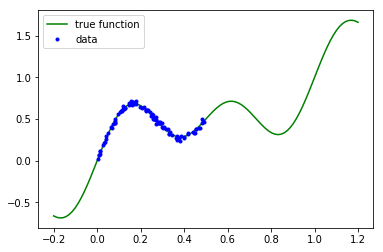

In [6]:
# Choose the problem
problem = 'last' #'cubic' or 'sin_cos'
n_data = 100
f, var_n, bounds, xn, yn, x_plot, y_plot, units_per_layer, prior = set_problem(problem, n_data)
pre_model = build_scaling_layers(X_train = xn)
kwargs = {'var_n': var_n, 'units_per_layer':units_per_layer, 'prior': prior, 'pre_model': pre_model}

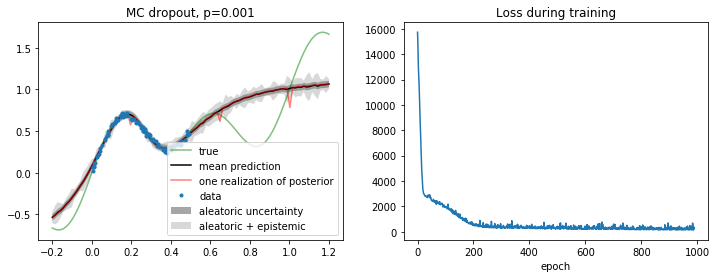

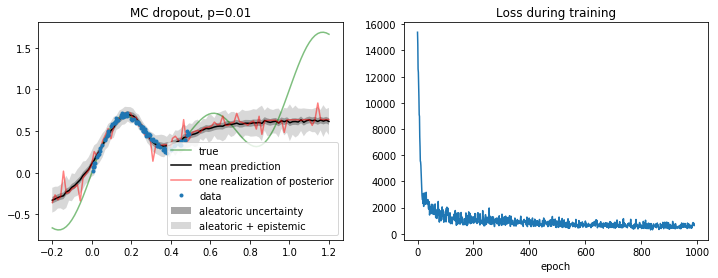

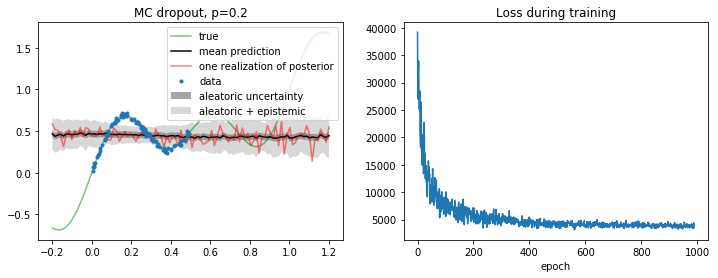

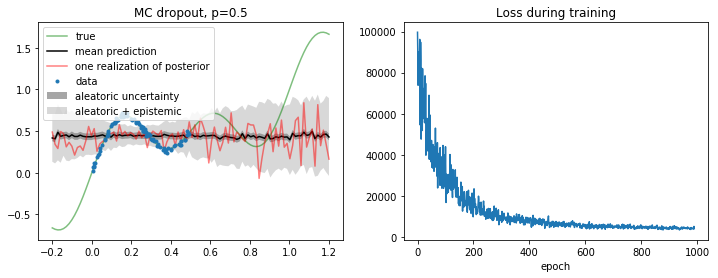

In [7]:
rates = [0.001, 0.01, 0.2, 0.5]

for dropout_rate in rates:
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
    reg = MCdropoutRegressor(dropout_rate=dropout_rate, lr = 0.001, **kwargs)
    epochs = 1000
    reg.fit(xn, yn, epochs=epochs)
    plot_regressor(reg, x_plot, y_plot, xn, yn, ax[0], 'MC dropout, p={}'.format(dropout_rate))
    ax[1].plot(reg.loss_history[10:]); ax[1].set_title('Loss during training'); ax[1].set_xlabel('epoch')
    plt.show(fig)

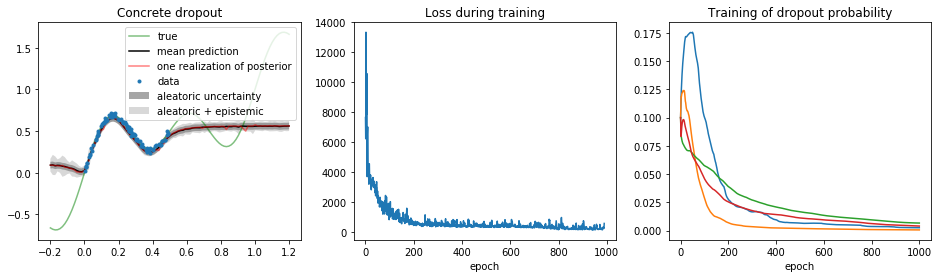

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
reg = MCdropoutRegressor(concrete_dropout=True, lr=0.1, **kwargs)
reg.fit(xn, yn, epochs=1000)
plot_regressor(reg, x_plot, y_plot, xn, yn, ax[0], 'Concrete dropout')
ax[1].plot(reg.loss_history[10:]); ax[1].set_title('Loss during training'); ax[1].set_xlabel('epoch')
for l in range(reg.dropout_history.shape[1]):
    ax[2].plot(reg.dropout_history[:,l])
ax[2].set_title('Training of dropout probability'); ax[2].set_xlabel('epoch')
plt.show(fig)